In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Load dataset (if not already loaded)
df = pd.read_csv("tic_tac_toe_data.csv")

# Map board positions to readable labels
pos_labels = {
    '0-0': 'Top-Left',     '0-1': 'Top-Center',     '0-2': 'Top-Right',
    '1-0': 'Middle-Left',  '1-1': 'Middle-Center',  '1-2': 'Middle-Right',
    '2-0': 'Bottom-Left',  '2-1': 'Bottom-Center',  '2-2': 'Bottom-Right'
}

# Define the colors (make sure order matches the index)
colors = ['skyblue', 'lightsalmon', 'lightgreen']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

In [35]:
# For each X opening move, see which O counter (Move 2-O) leads to wins
o_counters = df[df['Winner'] == 'O'].groupby(['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)']).size().reset_index(name='wins')
total_o_attempts = df.groupby(['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)']).size().reset_index(name='total')
merged = pd.merge(total_o_attempts, o_counters, how='left', on=['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)'])
merged['wins'] = merged['wins'].fillna(0)
merged['win_rate'] = merged['wins'] / merged['total']

# Sort by win_rate to find best counters
best_counters = merged.sort_values(['Move 1-X (Row-Col)', 'win_rate'], ascending=[True, False])
best_counters.head()

,Move 1-X (Row-Col),Move 2-O (Row-Col),total,wins,win_rate
3,0-0,1-1,3468,1312,0.378316
1,0-0,0-2,3540,1132,0.319774
5,0-0,2-0,3540,1132,0.319774
4,0-0,1-2,3126,936,0.299424
6,0-0,2-1,3126,936,0.299424


##### What is the best counter move overall?

This returns the top-performing counter moves regardless of X’s opening move

In [36]:
best_counters.sort_values(by='win_rate', ascending=False).head(10)


,Move 1-X (Row-Col),Move 2-O (Row-Col),total,wins,win_rate
44,1-2,1-1,3810,1652,0.433596
60,2-1,1-1,3810,1652,0.433596
27,1-0,1-1,3810,1652,0.433596
11,0-1,1-1,3810,1652,0.433596
15,0-1,2-2,3396,1456,0.428740
13,0-1,2-0,3396,1456,0.428740
31,1-0,2-2,3396,1456,0.428740
40,1-2,0-0,3396,1456,0.428740
45,1-2,2-0,3396,1456,0.428740
26,1-0,0-2,3396,1456,0.428740


##### What is the best counter to a specific X move?

Example below is for if X starts with 1-1. You can plug in any opening move you want to analyze

In [37]:
best_counters[best_counters['Move 1-X (Row-Col)'] == '1-1'].sort_values(by='win_rate', ascending=False)

,Move 1-X (Row-Col),Move 2-O (Row-Col),total,wins,win_rate
32,1-1,0-0,3198,792,0.247655
34,1-1,0-2,3198,792,0.247655
37,1-1,2-0,3198,792,0.247655
39,1-1,2-2,3198,792,0.247655
33,1-1,0-1,3270,612,0.187156
35,1-1,1-0,3270,612,0.187156
36,1-1,1-2,3270,612,0.187156
38,1-1,2-1,3270,612,0.187156


##### What’s the most popular counter (regardless of win rate)?

This helps identify commonly chosen counters — and you can cross-check if they're actually effective.

In [38]:
best_counters.sort_values(by='total', ascending=False).head(10)

,Move 1-X (Row-Col),Move 2-O (Row-Col),total,wins,win_rate
57,2-1,0-1,4066,900,0.221348
43,1-2,1-0,4066,900,0.221348
14,0-1,2-1,4066,900,0.221348
28,1-0,1-2,4066,900,0.221348
8,0-1,0-0,3938,1276,0.324022
63,2-1,2-2,3938,1276,0.324022
24,1-0,0-0,3938,1276,0.324022
29,1-0,2-0,3938,1276,0.324022
9,0-1,0-2,3938,1276,0.324022
62,2-1,2-0,3938,1276,0.324022


##### Visualize a specific opening move


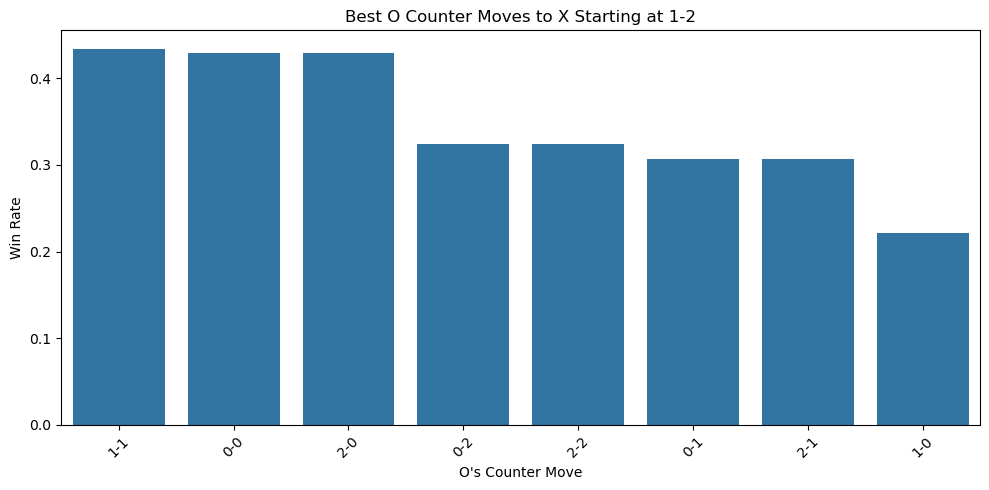

In [39]:
# Filter for a specific opening
subset = best_counters[best_counters['Move 1-X (Row-Col)'] == '1-2'].sort_values(by='win_rate', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=subset, x='Move 2-O (Row-Col)', y='win_rate')
plt.title("Best O Counter Moves to X Starting at 1-2")
plt.ylabel("Win Rate")
plt.xlabel("O's Counter Move")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Frequency of Ties

In [40]:
tie_count = (df['Winner'] == '-').sum()
total_games = len(df)
tie_rate = tie_count / total_games
print(f"Ties: {tie_count} games ({tie_rate:.2%})")


Ties: 46080 games (18.06%)


### How to Avoid a Tie
**Strategy**
* Analyze what sequences lead to ties
* Compare them to sequences that lead to wins

Example: Most common 3-move openings in tie games

In [41]:
tie_games = df[df['Winner'] == '-']
tie_openings = tie_games[['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)', 'Move 3-X (Row-Col)']]
tie_patterns = tie_openings.apply(tuple, axis=1).value_counts().head(5)
print("Most common tie openings:")
print(tie_patterns)


Most common tie openings:
(1-2, 1-0, 2-0)    216
(1-0, 0-0, 2-2)    216
(1-2, 2-2, 0-0)    216
(0-0, 2-2, 1-2)    216
(1-2, 1-0, 0-0)    216
Name: count, dtype: int64


In [42]:
x_win_openings = df[df['Winner'] == 'X'][['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)', 'Move 3-X (Row-Col)']]
x_patterns = x_win_openings.apply(tuple, axis=1).value_counts()

# Check overlap and avoid repeated patterns
overlap = x_patterns[tie_patterns.index]
print("Overlap in X wins:")
print(overlap)

Overlap in X wins:
(1-2, 1-0, 2-0)    348
(1-0, 0-0, 2-2)    268
(1-2, 2-2, 0-0)    268
(0-0, 2-2, 1-2)    268
(1-2, 1-0, 0-0)    348
Name: count, dtype: int64


##### Tie-Prone vs Win-Prone O Moves (Turn 4)

/var/folders/pk/d9_1yzcs09l090ywbgh8b9kw0000gn/T/ipykernel_14087/3890000095.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=move_comparison_sorted, x='position_label', y='tie_to_win_ratio', palette=colors)
/var/folders/pk/d9_1yzcs09l090ywbgh8b9kw0000gn/T/ipykernel_14087/3890000095.py:14: UserWarning: 
The palette list has fewer values (3) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=move_comparison_sorted, x='position_label', y='tie_to_win_ratio', palette=colors)


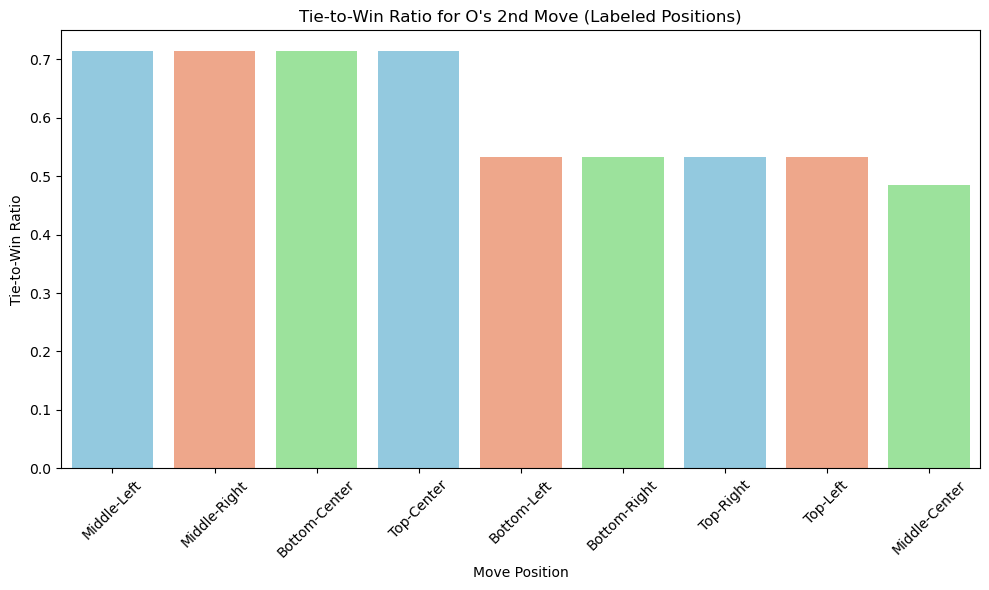

In [43]:
# Calculate tie and win counts for Move 4-O
tie_counts = df[df['Winner'] == '-']['Move 4-O (Row-Col)'].value_counts().rename('tie_count')
win_counts = df[df['Winner'] == 'O']['Move 4-O (Row-Col)'].value_counts().rename('win_count')

# Combine and calculate tie-to-win ratio
move_comparison = pd.concat([tie_counts, win_counts], axis=1).fillna(0)
move_comparison['tie_to_win_ratio'] = move_comparison['tie_count'] / (move_comparison['win_count'] + 1)
move_comparison['position_label'] = move_comparison.index.map(pos_labels)

# Sort and visualize
move_comparison_sorted = move_comparison.sort_values(by='tie_to_win_ratio', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=move_comparison_sorted, x='position_label', y='tie_to_win_ratio', palette=colors)
plt.title("Tie-to-Win Ratio for O's 2nd Move (Labeled Positions)")
plt.ylabel("Tie-to-Win Ratio")
plt.xlabel("Move Position")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### Full-Game Sequences That End in Ties 

In [44]:
# Select move columns
move_cols = [col for col in df.columns if col.startswith("Move")]

# Convert each move to labeled string and get full sequences from tie games
tie_sequences_labeled = (
    df[df['Winner'] == '-'][move_cols]
    .applymap(lambda x: pos_labels.get(x, x))  # Map labels
    .apply(tuple, axis=1)
    .value_counts()
    .head(5)
)

print("Most common full-game labeled sequences that end in ties:")
for seq, count in tie_sequences_labeled.items():
    print(f"{seq} — {count} time(s)")


/var/folders/pk/d9_1yzcs09l090ywbgh8b9kw0000gn/T/ipykernel_14087/1152448654.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda x: pos_labels.get(x, x))  # Map labels


Most common full-game labeled sequences that end in ties:
('Top-Left', 'Top-Center', 'Top-Right', 'Middle-Left', 'Middle-Center', 'Bottom-Left', 'Middle-Right', 'Bottom-Right', 'Bottom-Center') — 1 time(s)
('Bottom-Left', 'Top-Left', 'Middle-Left', 'Top-Right', 'Top-Center', 'Bottom-Center', 'Middle-Right', 'Middle-Center', 'Bottom-Right') — 1 time(s)
('Bottom-Left', 'Top-Left', 'Middle-Left', 'Top-Right', 'Top-Center', 'Bottom-Center', 'Bottom-Right', 'Middle-Right', 'Middle-Center') — 1 time(s)
('Bottom-Left', 'Top-Left', 'Middle-Left', 'Top-Right', 'Middle-Center', 'Middle-Right', 'Top-Center', 'Bottom-Center', 'Bottom-Right') — 1 time(s)
('Bottom-Left', 'Top-Left', 'Middle-Left', 'Top-Right', 'Middle-Center', 'Middle-Right', 'Bottom-Right', 'Bottom-Center', 'Top-Center') — 1 time(s)


##### Heatmap: O’s Win Rate by X’s Opening and O’s Counter

Shows win rate patterns across all X vs O move pairings

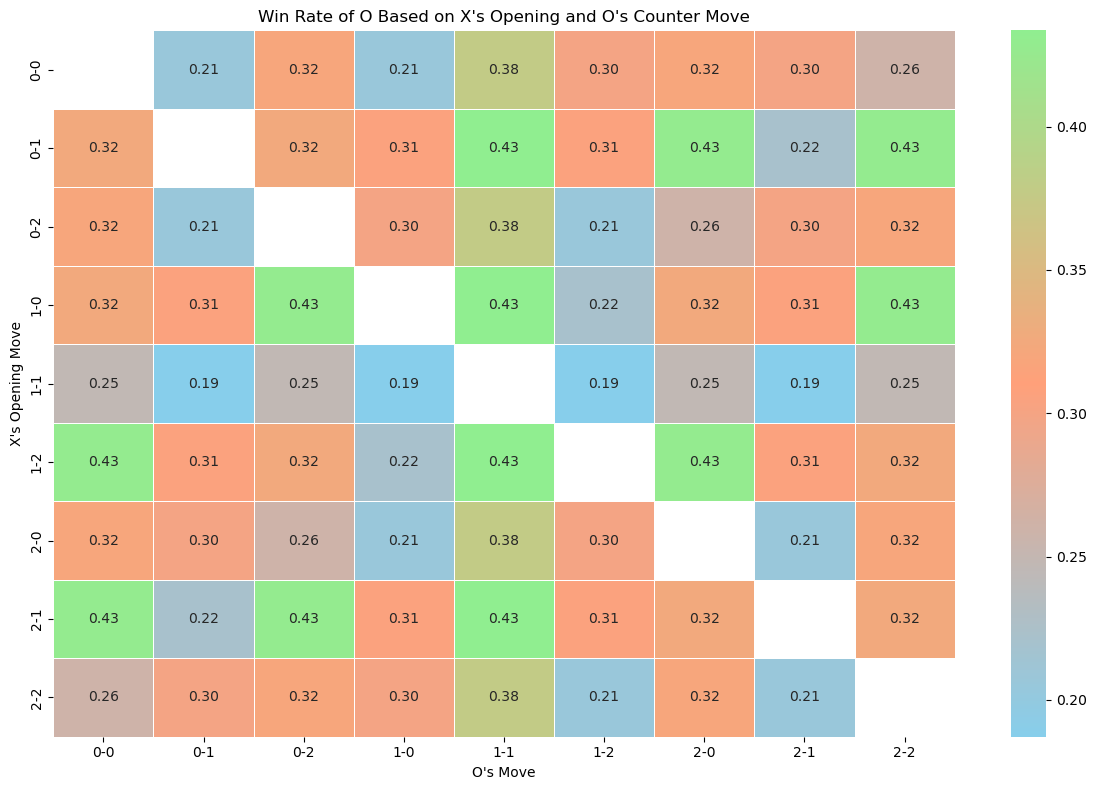

In [45]:
# Create a pivot table: rows = X move, columns = O counter, values = win_rate
pivot = best_counters.pivot(index='Move 1-X (Row-Col)', columns='Move 2-O (Row-Col)', values='win_rate')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=.5)
plt.title("Win Rate of O Based on X's Opening and O's Counter Move")
plt.xlabel("O's Move")
plt.ylabel("X's Opening Move")
plt.tight_layout()
plt.show()


##### Heatmap of Total Games Played for Each Pair


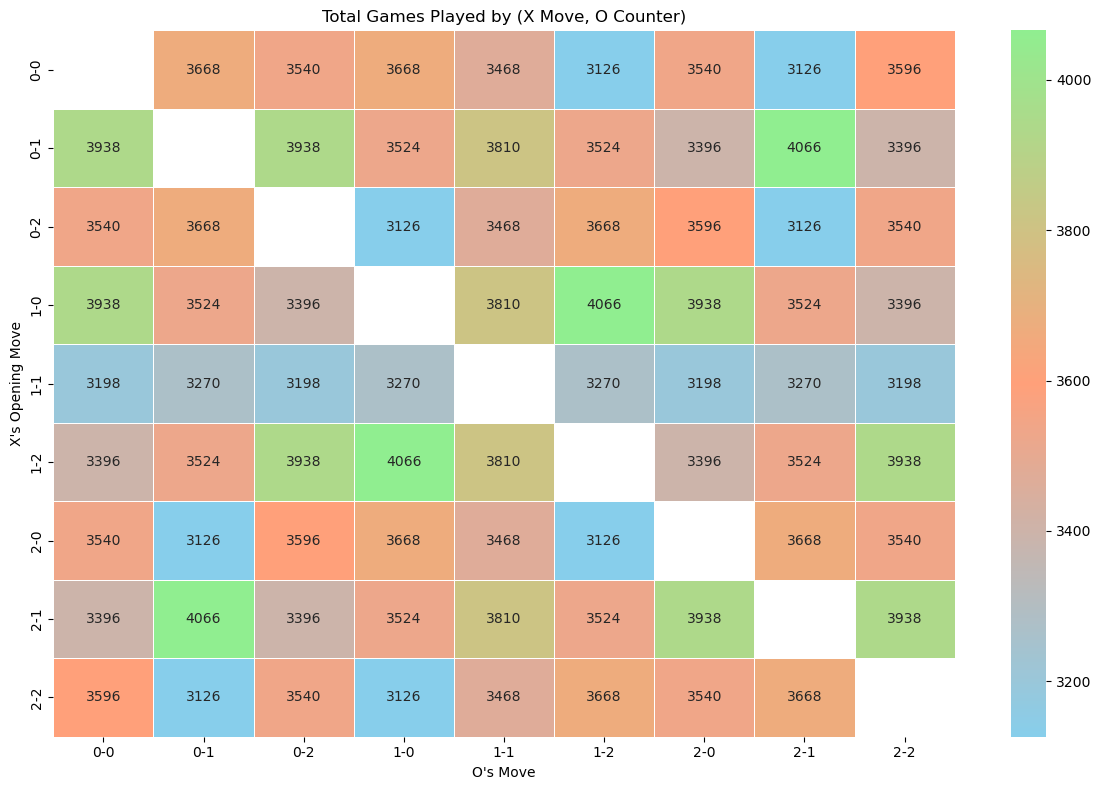

In [46]:
pivot_total = best_counters.pivot(index='Move 1-X (Row-Col)', columns='Move 2-O (Row-Col)', values='total')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_total, annot=True, fmt=".0f", cmap=custom_cmap, linewidths=.5)
plt.title("Total Games Played by (X Move, O Counter)")
plt.xlabel("O's Move")
plt.ylabel("X's Opening Move")
plt.tight_layout()
plt.show()


##### Group by Board Region (Center, Corner, Side)

In [47]:
def classify_position(pos):
    if pos == '1-1':
        return 'Center'
    elif pos in ['0-0', '0-2', '2-0', '2-2']:
        return 'Corner'
    elif pos in ['0-1', '1-0', '1-2', '2-1']:
        return 'Edge'
    return 'Other'

best_counters['O Position Type'] = best_counters['Move 2-O (Row-Col)'].apply(classify_position)
best_counters['X Opening Type'] = best_counters['Move 1-X (Row-Col)'].apply(classify_position)

# Aggregate win rate by O Position Type
pos_summary = best_counters.groupby('O Position Type')['win_rate'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)
print(pos_summary)


                     mean  count
O Position Type                 
Center           0.405956      8
Corner           0.331627     32
Edge             0.254063     32


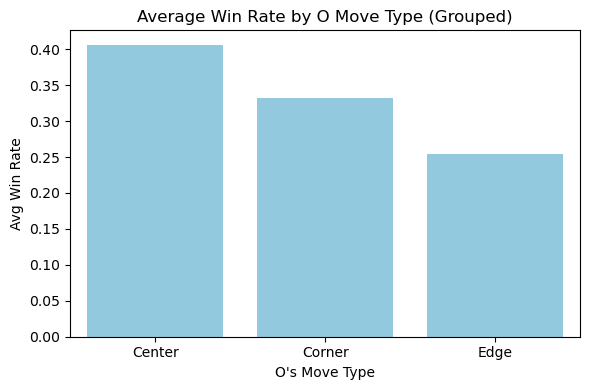

In [48]:
# Plot average win rate by O Position Type
plt.figure(figsize=(6, 4))
sns.barplot(data=pos_summary.reset_index(), x='O Position Type', y='mean', color=colors[0])
plt.title("Average Win Rate by O Move Type (Grouped)")
plt.ylabel("Avg Win Rate")
plt.xlabel("O's Move Type")
plt.tight_layout()
plt.show()


##### Rank Change from Popularity vs Win Rate

In [49]:
# Difference between popularity rank and win rate rank
best_counters['popularity_rank'] = best_counters.groupby('Move 1-X (Row-Col)')['total'].rank(ascending=False)
best_counters['winrate_rank'] = best_counters.groupby('Move 1-X (Row-Col)')['win_rate'].rank(ascending=False)
best_counters['rank_gap'] = best_counters['popularity_rank'] - best_counters['winrate_rank']

# Moves that are popular but underperforming
interesting = best_counters.sort_values('rank_gap', ascending=False).head(10)
print(interesting[['Move 1-X (Row-Col)', 'Move 2-O (Row-Col)', 'total', 'win_rate', 'rank_gap']])

   Move 1-X (Row-Col) Move 2-O (Row-Col)  total  win_rate  rank_gap
3                 0-0                1-1   3468  0.378316       5.0
15                0-1                2-2   3396  0.428740       5.0
58                2-1                0-2   3396  0.428740       5.0
52                2-0                1-1   3468  0.378316       5.0
45                1-2                2-0   3396  0.428740       5.0
40                1-2                0-0   3396  0.428740       5.0
68                2-2                1-1   3468  0.378316       5.0
31                1-0                2-2   3396  0.428740       5.0
26                1-0                0-2   3396  0.428740       5.0
19                0-2                1-1   3468  0.378316       5.0


##### Heatmap for Best O Moves on Turn 2

In [50]:
# All Move 2-O attempts
move2_total = df.groupby('Move 2-O (Row-Col)').size().reset_index(name='total')

# Only wins by O
move2_wins = df[df['Winner'] == 'O'].groupby('Move 2-O (Row-Col)').size().reset_index(name='wins')

# Merge + calculate win rate
move2_stats = pd.merge(move2_total, move2_wins, on='Move 2-O (Row-Col)', how='left')
move2_stats['wins'] = move2_stats['wins'].fillna(0)
move2_stats['win_rate'] = move2_stats['wins'] / move2_stats['total']

# Sort to find best second turn moves
move2_stats = move2_stats.sort_values(by='win_rate', ascending=False)


##### Template Function for Any Turn

In [51]:
def best_moves_by_turn(move_col, winner):
    total = df.groupby(move_col).size().reset_index(name='total')
    wins = df[df['Winner'] == winner].groupby(move_col).size().reset_index(name='wins')
    
    merged = pd.merge(total, wins, on=move_col, how='left')
    merged['wins'] = merged['wins'].fillna(0)
    merged['win_rate'] = merged['wins'] / merged['total']
    
    return merged.sort_values(by='win_rate', ascending=False)


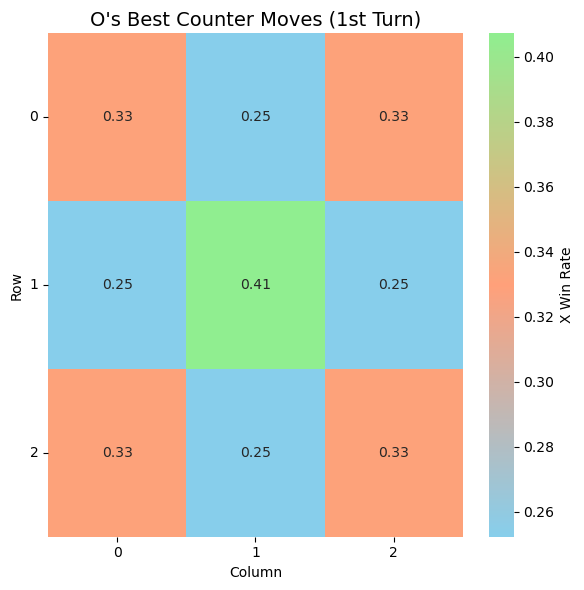

In [61]:
# Create dictionary to map move positions to board coordinates
pos_map = {
    '0-0': (0, 0), '0-1': (0, 1), '0-2': (0, 2),
    '1-0': (1, 0), '1-1': (1, 1), '1-2': (1, 2),
    '2-0': (2, 0), '2-1': (2, 1), '2-2': (2, 2),
}

# Create blank 3x3 grid to store win rates
board_grid = np.full((3, 3), np.nan)

# Use best_moves_by_turn function to get win rates
turn2_stats = best_moves_by_turn('Move 2-O (Row-Col)', 'O')

# Fill grid with win rates
for _, row in turn2_stats.iterrows():
    move = row['Move 2-O (Row-Col)']
    if move in pos_map:
        r, c = pos_map[move]
        board_grid[r, c] = row['win_rate']

# Plot as a Tic Tac Toe style board
plt.figure(figsize=(6, 6))
sns.heatmap(board_grid, annot=True, fmt=".2f", cmap=custom_cmap, cbar_kws={'label': 'X Win Rate'})
plt.xlabel('Column')
plt.ylabel('Row')
plt.xticks([0.5,1.5,2.5], ['0', '1', '2'])
plt.yticks([0.5,1.5,2.5], ['0', '1', '2'], rotation=0)
plt.title("O's Best Counter Moves (1st Turn)", fontsize=14)
plt.tight_layout()
plt.show()


##### Win Rate vs Popularity (O's 2nd Move)

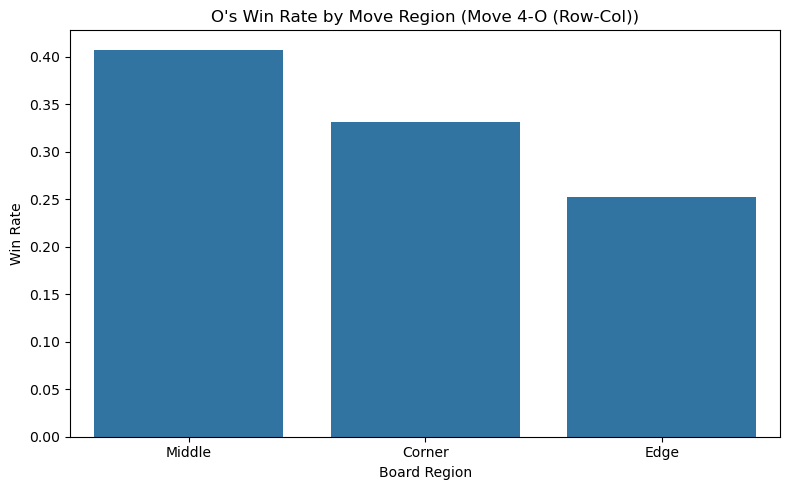

In [ ]:
# Classify move into position type
def classify_position(pos):
    if pos == '1-1':
        return 'Middle'
    elif pos in ['0-1', '1-0', '1-2', '2-1']:
        return 'Edge'
    elif pos in ['0-0', '0-2', '2-0', '2-2']:
        return 'Corner'
    return 'Other'

def winrate_vs_position_type(move_col, winner):
    filtered = df[df[move_col].notna() & (df[move_col] != '---')]
    
    total = filtered.groupby(move_col).size().reset_index(name='total')
    wins = filtered[filtered['Winner'] == winner].groupby(move_col).size().reset_index(name='wins')
    
    merged = pd.merge(total, wins, on=move_col, how='left')
    merged['wins'] = merged['wins'].fillna(0)
    merged['win_rate'] = merged['wins'] / merged['total']
    
    # Classify positions
    merged['position_type'] = merged[move_col].apply(classify_position)
    
    # Aggregate by region
    region_summary = merged.groupby('position_type')[['total', 'wins']].sum().reset_index()
    region_summary['win_rate'] = region_summary['wins'] / region_summary['total']
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=region_summary.sort_values(by='win_rate', ascending=False), x='position_type', y='win_rate')
    plt.title(f"{winner}'s Win Rate by Move Region ({move_col})")
    plt.ylabel("Win Rate")
    plt.xlabel("Board Region")
    plt.tight_layout()
    plt.show()

# Example for O’s 2nd move
winrate_vs_position_type('Move 4-O (Row-Col)', 'O')


##### Best O Counter by X’s Opening (Center vs Corner)

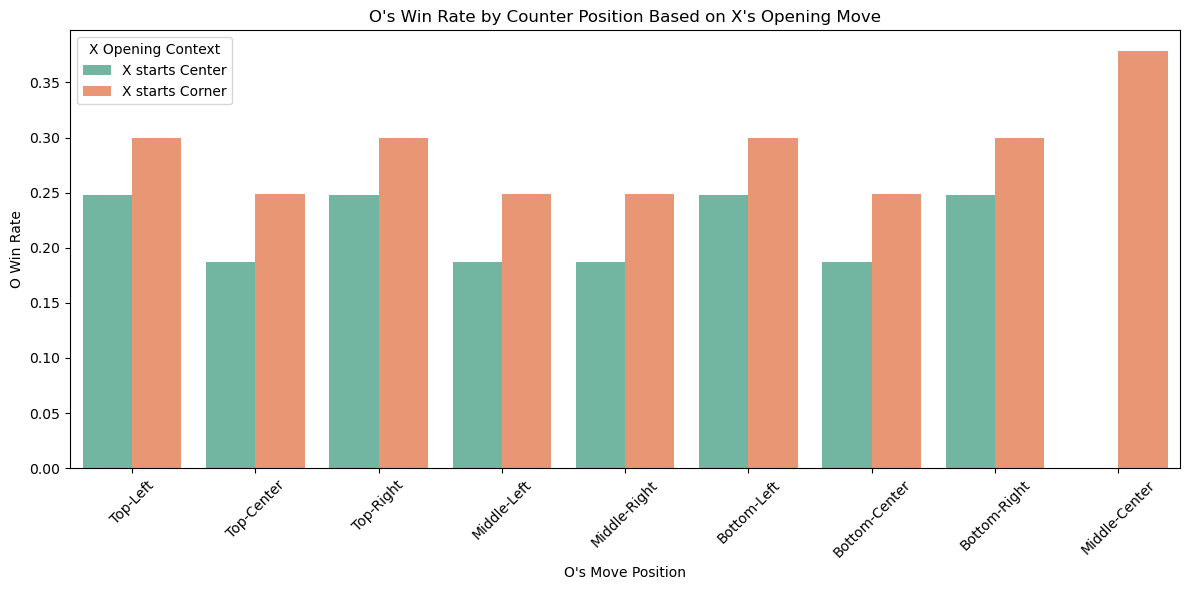

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("tic_tac_toe_data.csv")  # Adjust if needed

# Map positions to intuitive names
move_labels = {
    '0-0': 'Top-Left',     '0-1': 'Top-Center',     '0-2': 'Top-Right',
    '1-0': 'Middle-Left',  '1-1': 'Middle-Center',  '1-2': 'Middle-Right',
    '2-0': 'Bottom-Left',  '2-1': 'Bottom-Center',  '2-2': 'Bottom-Right'
}

# Function to calculate win rates for O based on X's opening
def compare_o_counters_labeled(x_opener_moves, context_label, move_col='Move 2-O (Row-Col)'):
    subset = df[df['Move 1-X (Row-Col)'].isin(x_opener_moves)]
    filtered = subset[subset[move_col].notna() & (subset[move_col] != '---')]

    total = filtered.groupby(move_col).size().reset_index(name='total')
    wins = filtered[filtered['Winner'] == 'O'].groupby(move_col).size().reset_index(name='wins')

    merged = pd.merge(total, wins, on=move_col, how='left')
    merged['wins'] = merged['wins'].fillna(0)
    merged['win_rate'] = merged['wins'] / merged['total']
    merged['context'] = context_label
    merged['position_label'] = merged[move_col].map(move_labels)

    return merged

# Compare two contexts
center_df = compare_o_counters_labeled(['1-1'], 'X starts Center')
corner_df = compare_o_counters_labeled(['0-0', '0-2', '2-0', '2-2'], 'X starts Corner')

# Combine and plot
combined_df = pd.concat([center_df, corner_df])

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x='position_label', y='win_rate', hue='context', palette='Set2', color=custom_cmap)
plt.title("O's Win Rate by Counter Position Based on X's Opening Move")
plt.ylabel("O Win Rate")
plt.xlabel("O's Move Position")
plt.legend(title='X Opening Context')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
